# ARIMA, SARIMA, SARIMAX

## Libraries

In [115]:
import sys
import os

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

sys.path.append(os.path.abspath(".."))

from tools.metrics import measuring_predictions, model_assessment

# Arima

In [50]:
df = pd.read_csv(
    "./data/daily_revenue.csv", 
    parse_dates=True, 
    index_col="date",
    dayfirst=True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [51]:
df.index.freq = "D"

In [52]:
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   revenue        1795 non-null   str  
 1   discount_rate  1795 non-null   str  
 2   coupon_rate    1795 non-null   str  
dtypes: str(3)
memory usage: 56.1 KB


In [53]:
df["revenue"] = df["revenue"].apply(lambda x: x.replace(",", "")).astype(float)

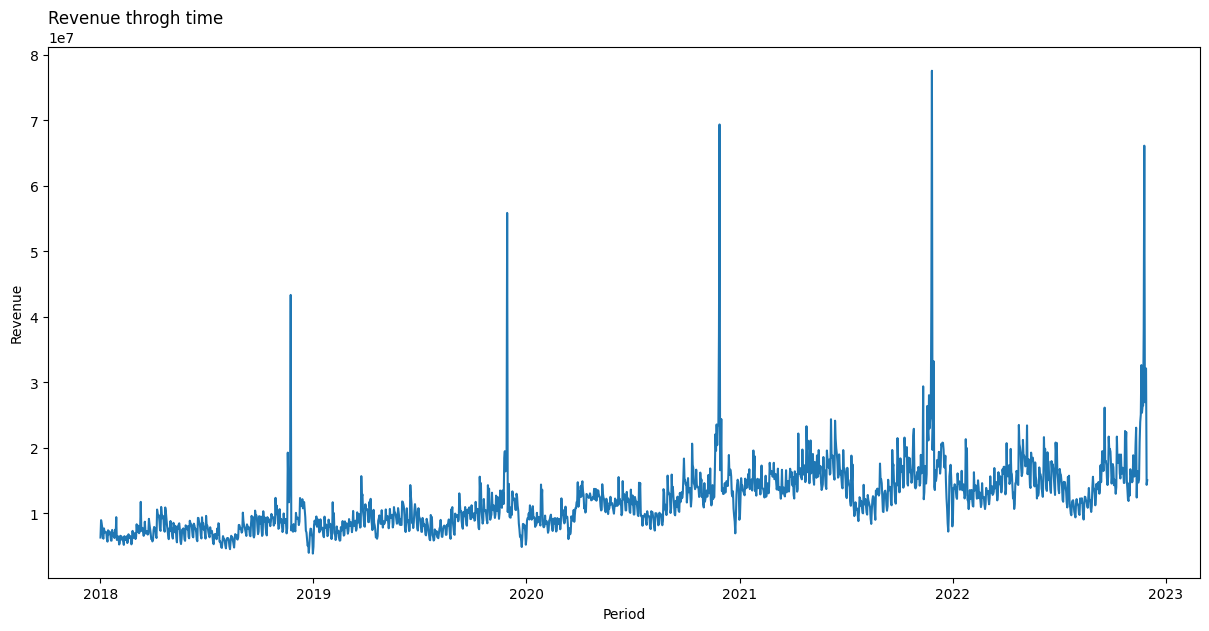

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(df["revenue"])
plt.tight_layout()
plt.title("Revenue throgh time", loc="left")
plt.xlabel("Period")
plt.ylabel("Revenue")
plt.show()

### Proving Seasonality Model

In [55]:
add_curve = seasonal_decompose(df["revenue"], model="add")
mul_curve = seasonal_decompose(df["revenue"], model="mul")

add_std = add_curve.resid.dropna().std()
mul_std = mul_curve.resid.dropna().std()

print("Additive Standard Deviation: ", add_std)
print("Multiplicative Standard Deviation: ", mul_std)

Additive Standard Deviation:  2433620.7687852536
Multiplicative Standard Deviation:  0.1285596370807388


The seasonlity of the curve is proved to be **Multiplicative**

obs: The lower values proves itself

### Seasonal Decomposition

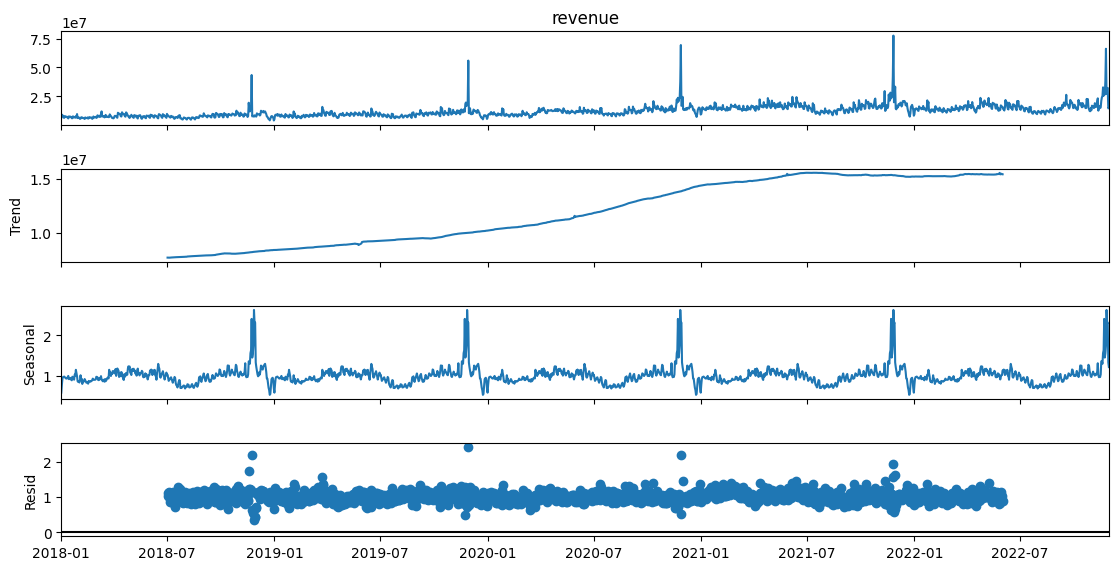

In [56]:
decomposition = seasonal_decompose(df["revenue"], model="mul", period=365)

fig = decomposition.plot()
fig.set_size_inches((12,6))
plt.show()

### Autocorrelation and Partial Autocorrelation

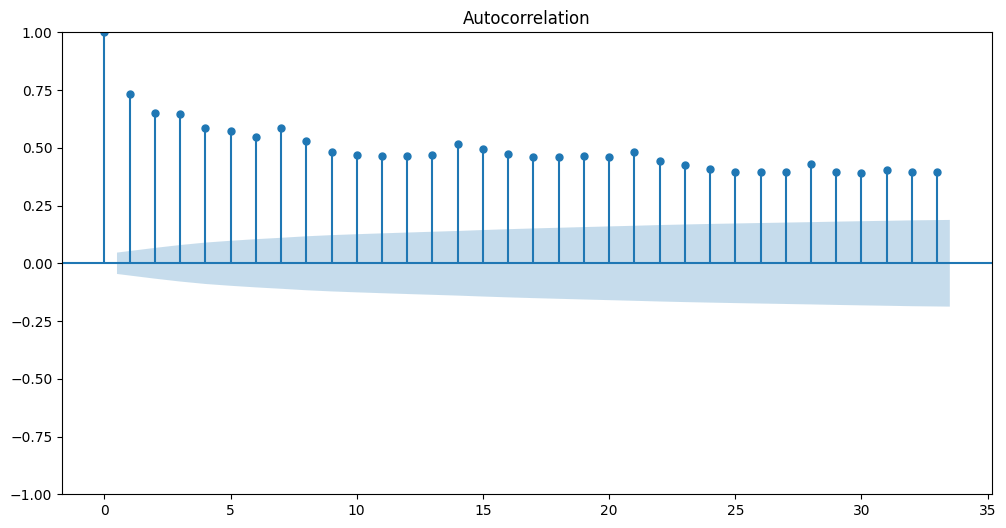

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(x=df["revenue"], ax=ax)
plt.show()

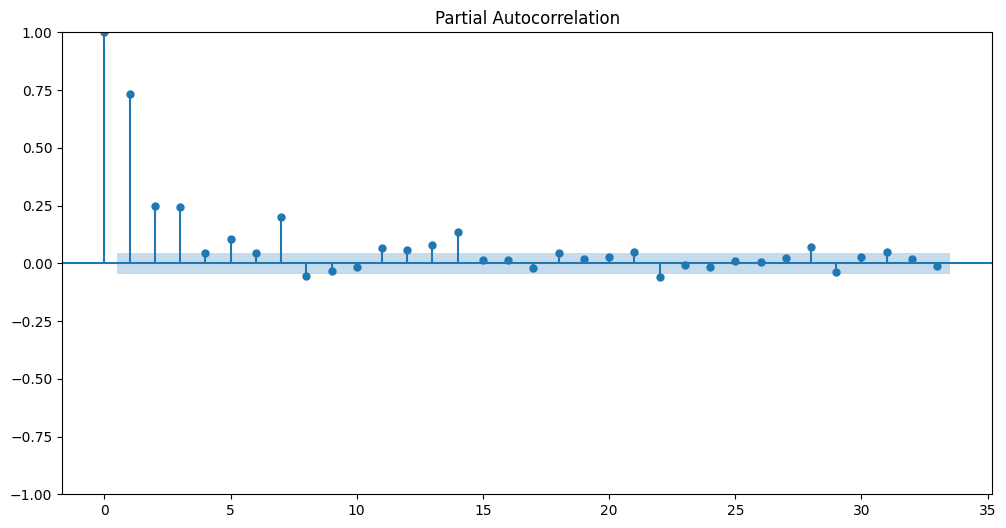

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(x=df["revenue"], ax=ax)
plt.show()

### Stationarity

In [59]:
def stationarity_information(x: pd.Series):
    adf_test = adfuller(x)

    p_value = round(adf_test[1], 5)
    if p_value > 0.05:
        print(f"The time series has a stationarity p-value of: {p_value}. Time Series IS NOT STATIONARY")
    else:
        print(f"The time series has a stationarity p-value of: {p_value}. Time Series IS STATIONARY")

In [60]:
stationarity_information(df["revenue"])

The time series has a stationarity p-value of: 0.1019. Time Series IS NOT STATIONARY


### Differencing the data

In [61]:
df["revenue_diff"] = df["revenue"].diff()
df = df.dropna()

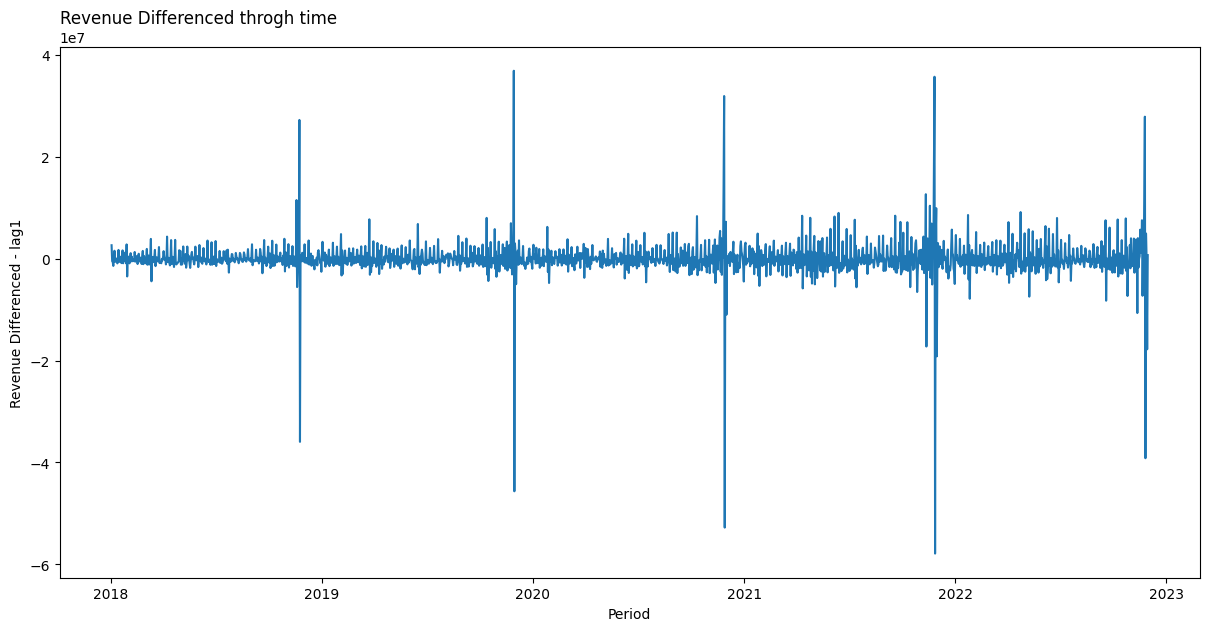

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(df["revenue_diff"])
plt.tight_layout()
plt.title("Revenue Differenced throgh time", loc="left")
plt.xlabel("Period")
plt.ylabel("Revenue Differenced - lag1")
plt.show()

In [63]:
stationarity_information(df["revenue_diff"])

The time series has a stationarity p-value of: 0.0. Time Series IS STATIONARY


### Splitting data into **Train** and **Test**

In [64]:
periods = 30
train = df[:-periods]
test = df[-periods:]

## ARIMA

In [65]:
# Creating ARIMA model
# In the case I'll be using a SARIMAX class, but the parameters configuration will create an ARIMA

arima_model = SARIMAX(
    endog=train["revenue"],
    order=(3, 1 ,1), # p, d, q (AR, I, MA) # AR=3, por que no PACF, o terceiro dia foi o último com grande autocorrelação
    seasonal_order=(0, 0, 0, 0)
).fit()

print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                 1764
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -28811.913
Date:                Sat, 21 Feb 2026   AIC                          57633.826
Time:                        11:21:50   BIC                          57661.199
Sample:                    01-02-2018   HQIC                         57643.941
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3557      0.014     24.681      0.000       0.327       0.384
ar.L2          0.0242      0.020      1.224      0.221      -0.015       0.063
ar.L3          0.1274      0.022      5.801      0.0

In [66]:
# Predict with ARIMA model

arima_results = arima_model.forecast(steps=periods)

In [67]:
measuring_predictions(test["revenue"], arima_results)

Mean Absolute Error: 7276547.96
Root Mean Squared Error: 12375215.42
Mean Absolute Percentage Error: 24.18%
Model's Accuracy: 75.82%


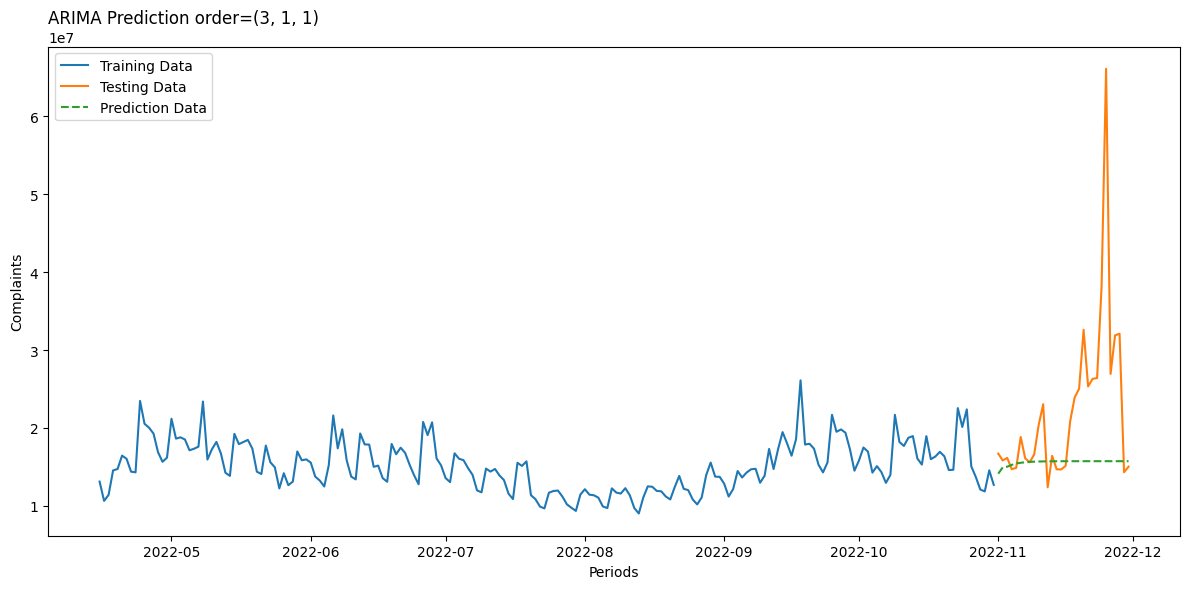

In [68]:
model_assessment(train[-200:]["revenue"], test[-200:]["revenue"], arima_results, "ARIMA Prediction order=(3, 1, 1)")

In [69]:
arima_model_resids = arima_model.resid

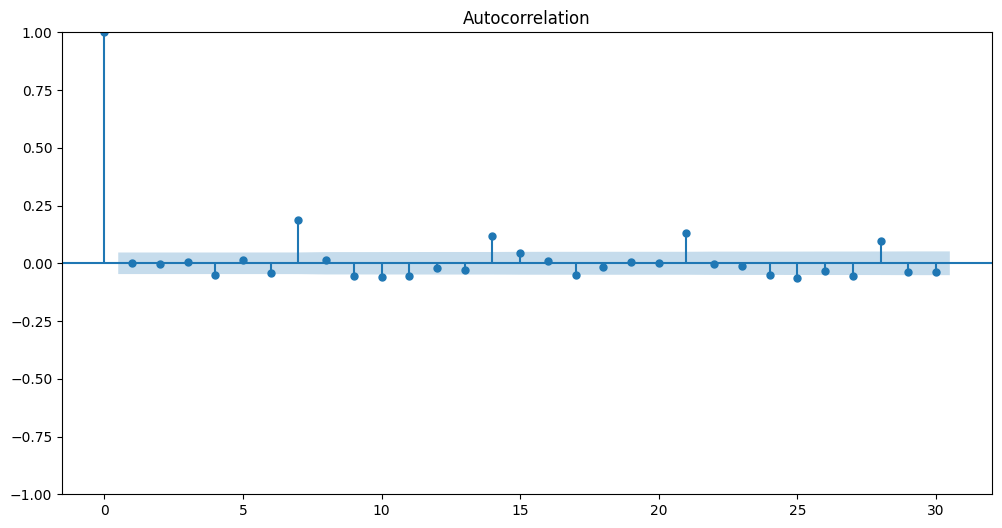

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(arima_model_resids, lags=30, ax=ax)
plt.show()

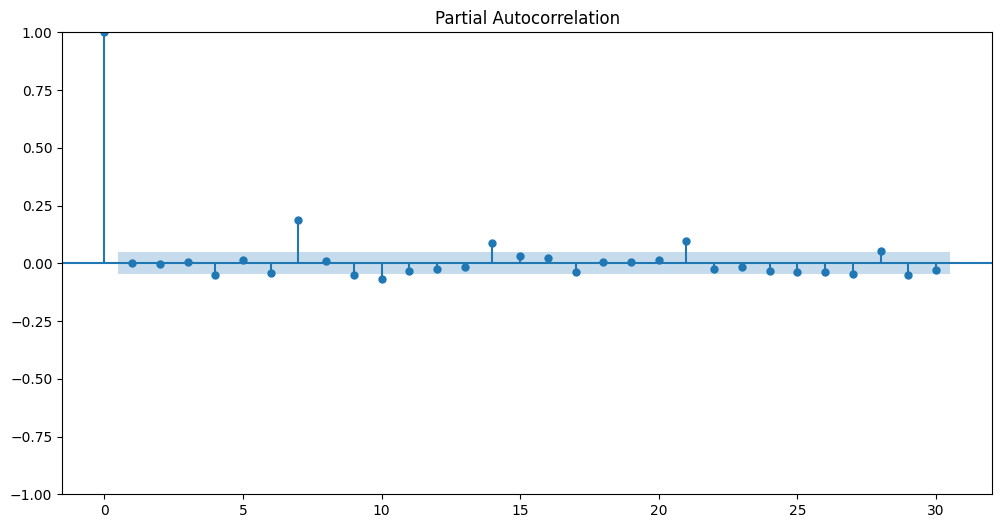

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(arima_model_resids, lags=30, ax=ax)
plt.show()

# SARIMA

In [72]:
# Building SARIMA model

sarima_model = SARIMAX(
    endog=train["revenue"],
    order=(3, 1, 1),
    seasonal_order=(1, 0, 1, 7)
).fit()
"""
seasonal_order=(1, 0, 1, 7)
Feito olhando os resíduos do modelo ARIMA com os gráficos de PACF e ACF
AR=1 para um pico forte em Lag=7. 1 AR para o Lag 7, se eu colocasse 2 AR, seria Lag 14. E por ai vai.
Coloca-se lag7 por que é mais forte que o Lag14

MA=1, seguindo a mesma lógica anterior.
"""

sarima_model.summary()

c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           revenue   No. Observations:                 1764
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -28724.677
Date:                           Sat, 21 Feb 2026   AIC                          57463.354
Time:                                   11:21:52   BIC                          57501.677
Sample:                               01-02-2018   HQIC                         57477.515
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4393      0.009     47.964      0.000       0.421       0.457
ar.L2          0.0560      0.016      3.524      0.000       0.025       0.087
ar.L3          0.2047      0.020     10.061      0.000       0.165       0.245
ma.L1         -0.9919      0.006   -176.941      0.000      -1.003      -0.981
ar.S.L7        0.9991      0.002    661.475      0.000       0.996       1.002
ma.S.L7       -0.9851      0.006   -161.963      0.000      -0.997      -0.973
sigma2      9.935e+12   1.04e-15   9.51e+27      0.000    9.93e+12    9.93e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1102896.02
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             6.46
Prob(H) (two-sided):                  0.00   Kurtosis:                       124.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+42. Standard errors may be unstable.
"""

In [73]:
sarima_results = sarima_model.forecast(steps=periods)

In [74]:
measuring_predictions(test["revenue"], sarima_results)

Mean Absolute Error: 7620488.23
Root Mean Squared Error: 12686498.38
Mean Absolute Percentage Error: 25.73%
Model's Accuracy: 74.27%


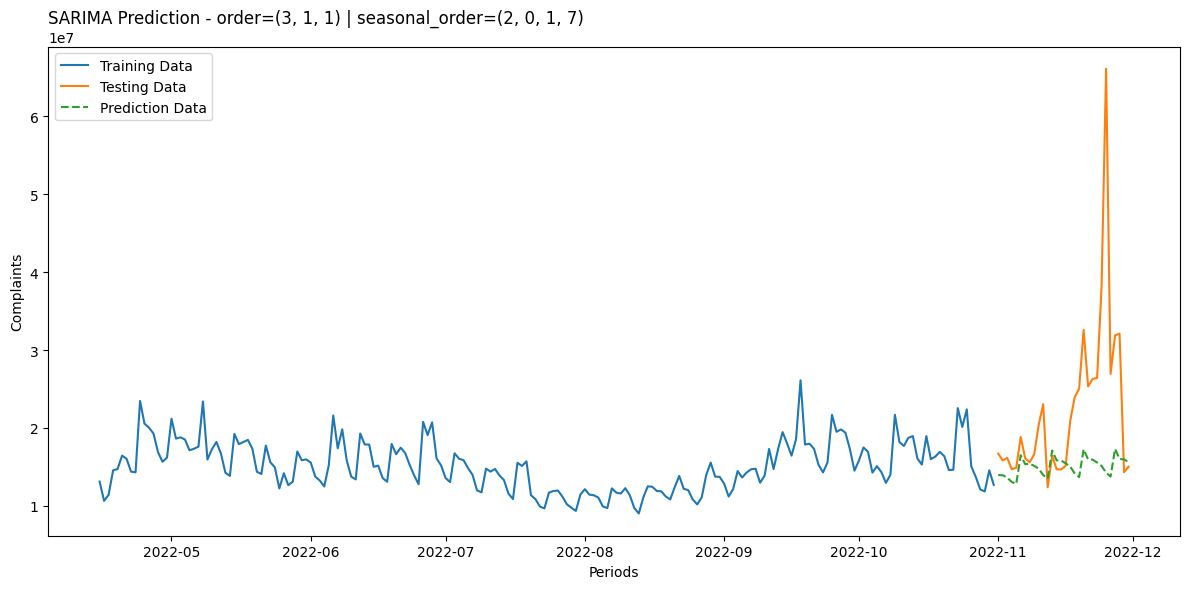

In [75]:
model_assessment(train[-200:]["revenue"], test[-200:]["revenue"], sarima_results, "SARIMA Prediction - order=(3, 1, 1) | seasonal_order=(2, 0, 1, 7)")

## SARIMAX  
##### SARIMA + Exogenous variables = SARIMAX

In [76]:
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1794 entries, 2018-01-02 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1794 non-null   float64
 1   discount_rate  1794 non-null   str    
 2   coupon_rate    1794 non-null   str    
 3   revenue_diff   1794 non-null   float64
dtypes: float64(2), str(2)
memory usage: 70.1 KB


In [77]:
df["discount_rate"] = df["discount_rate"].apply(lambda x: x.replace("%", "")).astype("float")
df["coupon_rate"] = df["coupon_rate"].apply(lambda x: x.replace("%", "")).astype("float")

In [82]:
df

,revenue,discount_rate,coupon_rate,revenue_diff
date,,,,
2018-01-02,8922076.0,30.87,1.08,2651237.0
2018-01-03,8446101.0,28.11,1.01,-475975.0
2018-01-04,7785798.0,27.32,0.96,-660303.0
2018-01-05,6375303.0,25.70,0.90,-1410495.0
2018-01-06,6095418.0,25.02,0.87,-279885.0
...,...,...,...,...
2022-11-26,26934947.0,30.41,0.38,-39180777.0
2022-11-27,31890868.0,29.75,0.35,4955921.0
2022-11-28,32100918.0,25.27,8.93,210050.0


In [88]:
train_sarimax = df[:-30]
test_sarimax = df[-30:]
exog_train = train_sarimax[["discount_rate", "coupon_rate"]]
exog_test = test_sarimax[["discount_rate", "coupon_rate"]]

In [86]:
sarimax_model = SARIMAX(
    endog=train["revenue"],
    exog=exog_train,
    order=(3, 1, 1),
    seasonal_order=(1, 0, 1, 7)
).fit()

sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           revenue   No. Observations:                 1764
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -28581.977
Date:                           Sat, 21 Feb 2026   AIC                          57181.953
Time:                                   11:27:11   BIC                          57231.226
Sample:                               01-02-2018   HQIC                         57200.161
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount_rate  4.049e+05   2.35e-09   1.72e+14      0.000    4.05e+05    4.05e+05
coupon_rate    9.221e+05   6.31e-09   1.46e+14      0.000    9.22e+05    9.22e+05
ar.L1             0.2911      0.026     11.154      0.000       0.240       0.342
ar.L2            -0.0062      0.019     -0.321      0.748      -0.044       0.031
ar.L3             0.0380      0.020      1.948      0.051      -0.000       0.076
ma.L1            -0.8362      0.024    -35.174      0.000      -0.883      -0.790
ar.S.L7           0.9996      0.001   1147.706      0.000       0.998       1.001
ma.S.L7          -0.9900      0.008   -121.119      0.000      -1.006      -0.974
sigma2         8.371e+12   6.93e-15   1.21e+27      0.000    8.37e+12    8.37e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1195881.18
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                             5.94
Prob(H) (two-sided):                  0.00   Kurtosis:                       130.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.54e+40. Standard errors may be unstable.
"""

In [92]:
sarimax_results = sarimax_model.forecast(steps=periods, exog=exog_test)

In [93]:
measuring_predictions(test["revenue"], sarimax_results)

Mean Absolute Error: 6343156.14
Root Mean Squared Error: 10993994.35
Mean Absolute Percentage Error: 21.87%
Model's Accuracy: 78.13%


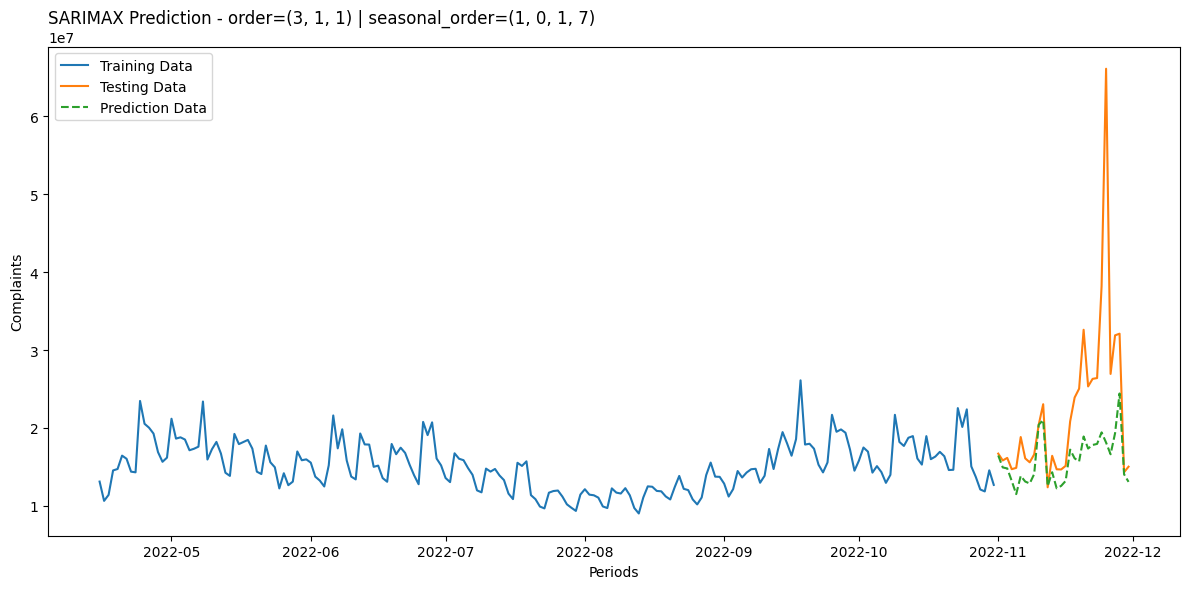

In [150]:
model_assessment(train[-200:]["revenue"], test[-200:]["revenue"], sarimax_results, "SARIMAX Prediction - order=(3, 1, 1) | seasonal_order=(1, 0, 1, 7)")

In [95]:
sarimax_model_resids = sarimax_model.resid

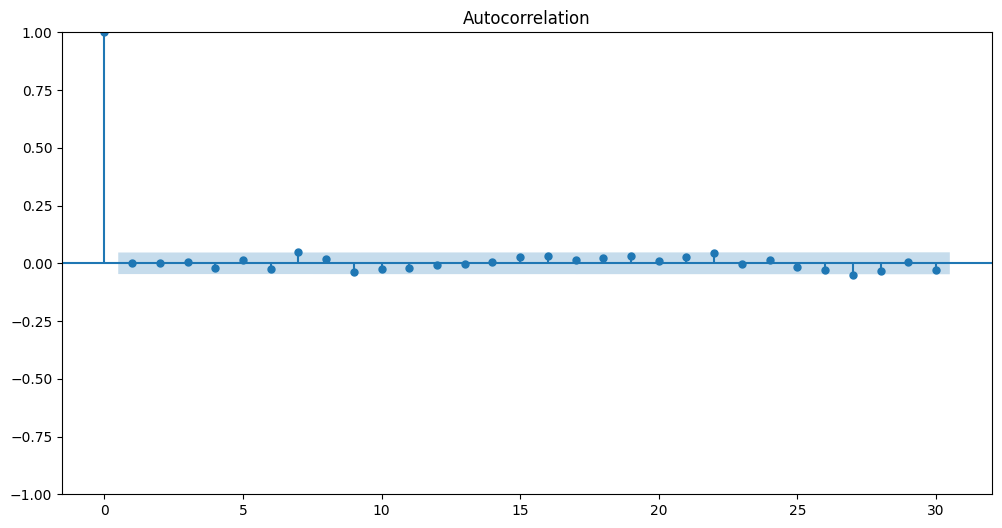

In [96]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(sarimax_model_resids, lags=30, ax=ax)
plt.show()

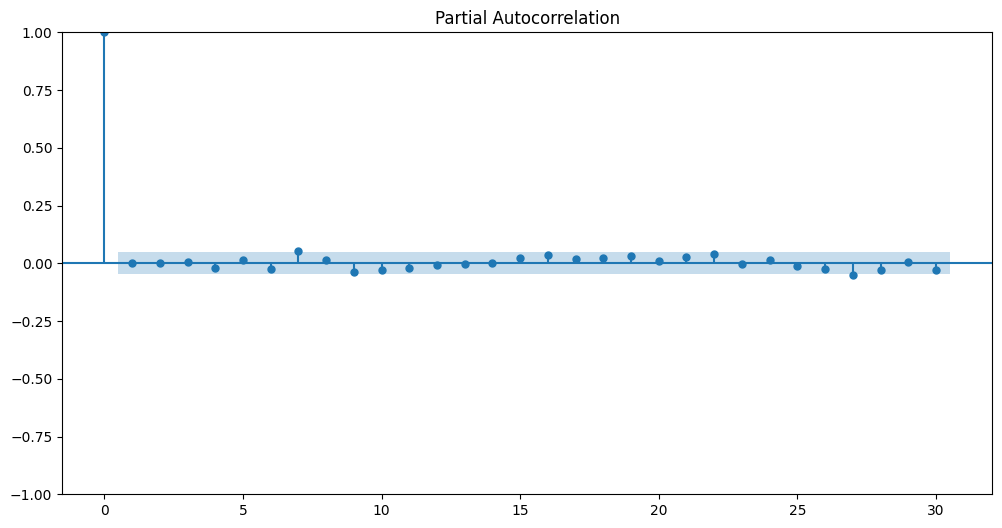

In [97]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(sarimax_model_resids, lags=30, ax=ax)
plt.show()

## Cross-Validation

In [99]:
order = (3, 1, 1)
seasonal_order = (1, 0, 1, 7)
n_splits = 5

In [101]:
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=periods)

In [113]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

cross_val_score = []

for train_index, test_index in tscv.split(df):
    _train = df.iloc[train_index]
    _test = df.iloc[test_index]

    # get exogenous data
    _exog_train = _train[["discount_rate", "coupon_rate"]]
    _exog_test = _test[["discount_rate", "coupon_rate"]]

    # building SARIMAX
    sarimax_model = SARIMAX(
        endog=_train["revenue"],
        exog=_exog_train,
        order=(3, 1, 1),
        seasonal_order=(1, 0, 1, 7)
    ).fit()

    # make predictions
    _sarimax_results = sarimax_model.forecast(steps=periods, exog=_exog_test)

    mae = mean_absolute_error(_test["revenue"], _sarimax_results)
    mape = mean_absolute_percentage_error(_test["revenue"], _sarimax_results)
    accuracy = 1 - mape

    # storing scores
    cross_val_score.append({
        "mae": mae,
        "mape": mape,
        "accuracy": accuracy,
    })

cross_val_score

[{'mae': 2386693.299332159,
  'mape': 0.20309998271804755,
  'accuracy': 0.7969000172819525},
 {'mae': 755639.9180668202,
  'mape': 0.061714649032886724,
  'accuracy': 0.9382853509671133},
 {'mae': 4308768.9782888405,
  'mape': 0.24833212453358164,
  'accuracy': 0.7516678754664183},
 {'mae': 2734161.0479215225,
  'mape': 0.18463535723656588,
  'accuracy': 0.8153646427634341},
 {'mae': 6343156.136555609,
  'mape': 0.2186599585793277,
  'accuracy': 0.7813400414206723}]

In [112]:
cross_val_score_df = pd.DataFrame(cross_val_score)
cross_val_score_df

,mae,mape,accuracy
0,2.386693e+06,0.203100,0.796900
1,7.556399e+05,0.061715,0.938285
2,4.308769e+06,0.248332,0.751668
3,2.734161e+06,0.184635,0.815365
4,6.343156e+06,0.218660,0.781340


### Parameters Tunning

In [122]:
params = {
    "p": [1, 3],
    "d": [1],
    "q": [1, 3],
    "P": [1, 3],
    "D": [0],
    "Q": [1, 3],
}

param_grid = ParameterGrid(params)

In [142]:
results_folder = []

# Getting the data
_train = df.iloc[:-periods]
_test = df.iloc[-periods:]

# get exogenous data
_exog_train = _train[["discount_rate", "coupon_rate"]]
_exog_test = _test[["discount_rate", "coupon_rate"]]

for params in param_grid:
    print(params)

    # Building the model
    sarimax_model = SARIMAX(
        endog=_train["revenue"],
        exog=_exog_train,
        order=(params["p"], params["d"], params["q"]),
        seasonal_order=(params["P"], params["D"], params["Q"], 7)
    ).fit()

    # Calculate errors and store results
    _sarimax_results = sarimax_model.forecast(steps=periods, exog=_exog_test)

    mae = mean_absolute_error(_test["revenue"], _sarimax_results)
    mape = mean_absolute_percentage_error(_test["revenue"], _sarimax_results)
    accuracy = 1 - mape

    results_folder.append({
        f"order: ({params["p"]}, {params["d"]}, {params["q"]}) | seasonal_order: ({params["P"]}, {params["D"]}, {params["Q"]})": {
            "mae": mae,
            "mape": mape,
            "accuracy": accuracy,
        }
    })

{'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 1}
{'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 3}
{'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 3, 'q': 1}
{'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 3, 'q': 3}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 1, 'Q': 3, 'd': 1, 'p': 1, 'q': 1}
{'D': 0, 'P': 1, 'Q': 3, 'd': 1, 'p': 1, 'q': 3}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 1, 'Q': 3, 'd': 1, 'p': 3, 'q': 1}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 1, 'Q': 3, 'd': 1, 'p': 3, 'q': 3}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 3, 'Q': 1, 'd': 1, 'p': 1, 'q': 1}
{'D': 0, 'P': 3, 'Q': 1, 'd': 1, 'p': 1, 'q': 3}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 3, 'Q': 1, 'd': 1, 'p': 3, 'q': 1}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 3, 'Q': 1, 'd': 1, 'p': 3, 'q': 3}
{'D': 0, 'P': 3, 'Q': 3, 'd': 1, 'p': 1, 'q': 1}
{'D': 0, 'P': 3, 'Q': 3, 'd': 1, 'p': 1, 'q': 3}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 3, 'Q': 3, 'd': 1, 'p': 3, 'q': 1}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'D': 0, 'P': 3, 'Q': 3, 'd': 1, 'p': 3, 'q': 3}


c:\Users\Vinicius\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [144]:
rows = []
for result in results_folder:
    for model, metrics in result.items():

        row = {
            "model": model,
            "mae": metrics["mae"],
            "mape": metrics["mape"],
            "accuracy": metrics["accuracy"],
        }

        rows.append(row)

df_results = pd.DataFrame(rows)
df_results

,model,mae,mape,accuracy
0,"order: (1, 1, 1) | seasonal_order: (1, 0, 1)",6.393884e+06,0.221083,0.778917
1,"order: (1, 1, 3) | seasonal_order: (1, 0, 1)",6.352456e+06,0.219178,0.780822
2,"order: (3, 1, 1) | seasonal_order: (1, 0, 1)",6.343156e+06,0.218660,0.781340
3,"order: (3, 1, 3) | seasonal_order: (1, 0, 1)",6.327396e+06,0.218197,0.781803
4,"order: (1, 1, 1) | seasonal_order: (1, 0, 3)",6.415755e+06,0.222351,0.777649
5,"order: (1, 1, 3) | seasonal_order: (1, 0, 3)",6.268275e+06,0.216961,0.783039
6,"order: (3, 1, 1) | seasonal_order: (1, 0, 3)",6.314396e+06,0.217600,0.782400
7,"order: (3, 1, 3) | seasonal_order: (1, 0, 3)",6.241714e+06,0.214459,0.785541
8,"order: (1, 1, 1) | seasonal_order: (3, 0, 1)",6.419788e+06,0.222547,0.777453
9,"order: (1, 1, 3) | seasonal_order: (3, 0, 1)",6.310211e+06,0.218696,0.781304


In [145]:
df_results.sort_values(by="accuracy", ascending=False).head(10)

,model,mae,mape,accuracy
11,"order: (3, 1, 3) | seasonal_order: (3, 0, 1)",6.206058e+06,0.212659,0.787341
7,"order: (3, 1, 3) | seasonal_order: (1, 0, 3)",6.241714e+06,0.214459,0.785541
5,"order: (1, 1, 3) | seasonal_order: (1, 0, 3)",6.268275e+06,0.216961,0.783039
6,"order: (3, 1, 1) | seasonal_order: (1, 0, 3)",6.314396e+06,0.217600,0.782400
10,"order: (3, 1, 1) | seasonal_order: (3, 0, 1)",6.319858e+06,0.217855,0.782145
3,"order: (3, 1, 3) | seasonal_order: (1, 0, 1)",6.327396e+06,0.218197,0.781803
2,"order: (3, 1, 1) | seasonal_order: (1, 0, 1)",6.343156e+06,0.218660,0.781340
9,"order: (1, 1, 3) | seasonal_order: (3, 0, 1)",6.310211e+06,0.218696,0.781304
1,"order: (1, 1, 3) | seasonal_order: (1, 0, 1)",6.352456e+06,0.219178,0.780822
15,"order: (3, 1, 3) | seasonal_order: (3, 0, 3)",6.333362e+06,0.219389,0.780611


In [146]:
sarimax_model_v1 = SARIMAX(
    endog=train["revenue"],
    exog=exog_train,
    order=(3, 1, 3),
    seasonal_order=(3, 0, 1, 7)
).fit()

sarimax_model_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             revenue   No. Observations:                 1764
Model:             SARIMAX(3, 1, 3)x(3, 0, [1], 7)   Log Likelihood              -28569.497
Date:                             Sat, 21 Feb 2026   AIC                          57164.995
Time:                                     12:43:36   BIC                          57236.167
Sample:                                 01-02-2018   HQIC                         57191.295
                                      - 10-31-2022                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount_rate  4.049e+05   7.66e-06   5.29e+10      0.000    4.05e+05    4.05e+05
coupon_rate    9.221e+05   4.55e-06   2.03e+11      0.000    9.22e+05    9.22e+05
ar.L1             0.2753      0.738      0.373      0.709      -1.171       1.722
ar.L2             0.9882      0.944      1.047      0.295      -0.862       2.839
ar.L3            -0.2864      0.213     -1.347      0.178      -0.703       0.130
ma.L1            -0.8204      0.737     -1.113      0.266      -2.265       0.624
ma.L2            -0.9988      1.346     -0.742      0.458      -3.637       1.639
ma.L3             0.8205      0.610      1.345      0.179      -0.375       2.016
ar.S.L7           1.0468      0.021     49.309      0.000       1.005       1.088
ar.S.L14         -0.0495      0.060     -0.821      0.412      -0.168       0.069
ar.S.L21          0.0017      0.057      0.030      0.976      -0.110       0.114
ma.S.L7          -0.9848      0.011    -89.087      0.000      -1.006      -0.963
sigma2         7.974e+12   7.74e-12   1.03e+24      0.000    7.97e+12    7.97e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):           1244696.98
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             6.07
Prob(H) (two-sided):                  0.00   Kurtosis:                       132.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.05e+38. Standard errors may be unstable.
"""

In [147]:
sarimax_results_v1 = sarimax_model_v1.forecast(steps=periods, exog=exog_test)

In [148]:
measuring_predictions(test["revenue"], sarimax_results_v1)

Mean Absolute Error: 6206058.05
Root Mean Squared Error: 10881027.21
Mean Absolute Percentage Error: 21.27%
Model's Accuracy: 78.73%


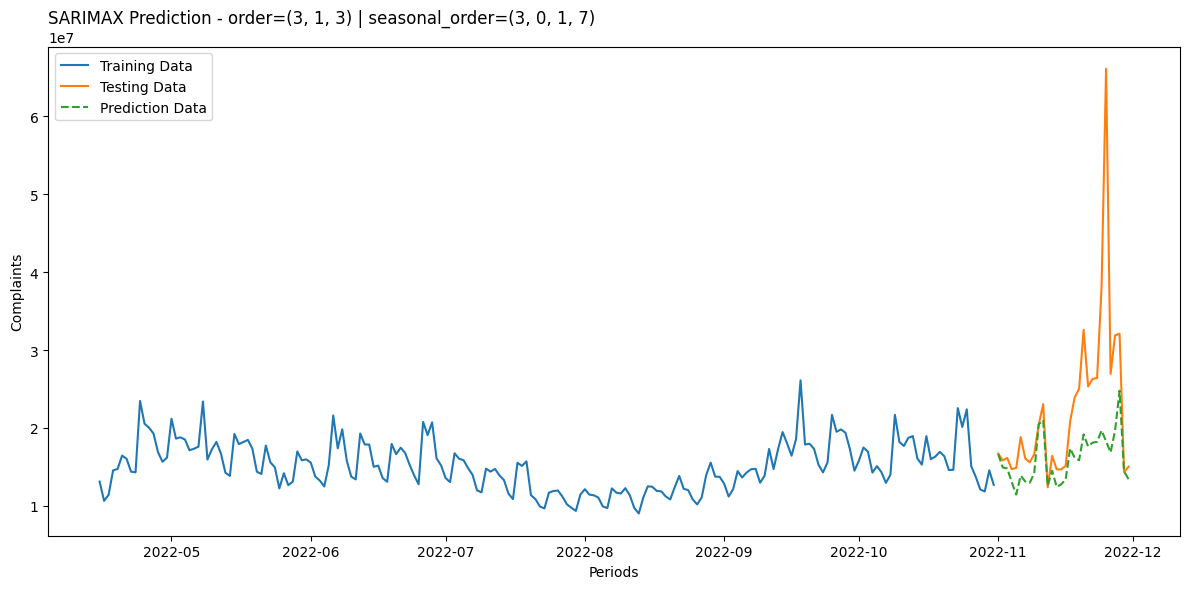

In [151]:
model_assessment(train[-200:]["revenue"], test[-200:]["revenue"], sarimax_results_v1, "SARIMAX Prediction - order=(3, 1, 3) | seasonal_order=(3, 0, 1, 7)")

## Predicting the Future